<a href="https://colab.research.google.com/github/smbonilla/learningPyTorch/blob/main/04_pyTorchCustomDatasets.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 04. PyTorch Custom Datasets Video Notebook 

How do you get your own data into PyTorch? 

One of the ways to do so is via custom datasets. 

## 0. Importing PyTorch and setting up device-agnostic code

In [1]:
import torch
from torch import nn

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

## 1. Get data

Our dataset is a subset of the Food101 dataset and 1000 images per class (750 training, 250 testing) 

Food101 starts with 101 different classes of food. Our dataset starts with 3 classes of food and only 10% of the images.

When starting out ML projects, it's important to try things on a small scale and then increase the scale when necessary 

In [2]:
import requests
import zipfile
from pathlib import Path

# Setup path to a data folder 
data_path = Path("data/")
image_path = data_path / "pizza_steak_sushi"

# if image folder doesn't exist, download
if image_path.is_dir():
  print(f"{image_path} directory already exists ... skipping download")
else:
  print(f"{image_path} directory doesn't exist, creating one...")
  image_path.mkdir(parents=True, exist_ok=True)

# Download pizza, steak and sushi data 
with open(data_path / "pizza_steak_sushi.zip", "wb") as f:
  request = requests.get("https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip")
  print(f"Downloading pizza, steak, and sushi data...")
  f.write(request.content)

f.close()

# unzip pizza, steak, sushi data
with zipfile.ZipFile(data_path / "pizza_steak_sushi.zip", "r") as zip_ref:
  print("Unzipping pizza, steak, and sushi data...")
  zip_ref.extractall(image_path)

data/pizza_steak_sushi directory doesn't exist, creating one...
Unzipping pizza, steak, and sushi data...


## 2. Becoming one with the data (data preparation and data exploration)

In [3]:
import os 
def walkThroughDir(dirPath):
  """
  Walks through dirPath returning its contents.
  """
  for dirpath, dirnames, filenames in os.walk(dirPath):
    print(f"There are {len(dirnames)} directories and {len(filenames)} images in '{dirpath}'.")

In [4]:
walkThroughDir(image_path)

There are 2 directories and 0 images in 'data/pizza_steak_sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/train'.
There are 0 directories and 75 images in 'data/pizza_steak_sushi/train/steak'.
There are 0 directories and 78 images in 'data/pizza_steak_sushi/train/pizza'.
There are 0 directories and 72 images in 'data/pizza_steak_sushi/train/sushi'.
There are 3 directories and 0 images in 'data/pizza_steak_sushi/test'.
There are 0 directories and 19 images in 'data/pizza_steak_sushi/test/steak'.
There are 0 directories and 25 images in 'data/pizza_steak_sushi/test/pizza'.
There are 0 directories and 31 images in 'data/pizza_steak_sushi/test/sushi'.


In [5]:
# Setup train and testing paths
trainDir = image_path / "train"
testDir = image_path / "test"

trainDir, testDir

(PosixPath('data/pizza_steak_sushi/train'),
 PosixPath('data/pizza_steak_sushi/test'))

### 2.1 Visualizing an image

1. get all of the image paths
2. pick a random path using `random.choice()`
3. get the image class name `using pathlib.Path.parent.stem`
4. open the image with Python's PIL
5. show image and print metadata

In [7]:
image_path

PosixPath('data/pizza_steak_sushi')

Random image path: data/pizza_steak_sushi/train/steak/1257104.jpg
Image class: steak
Image height: 341
Image width: 512


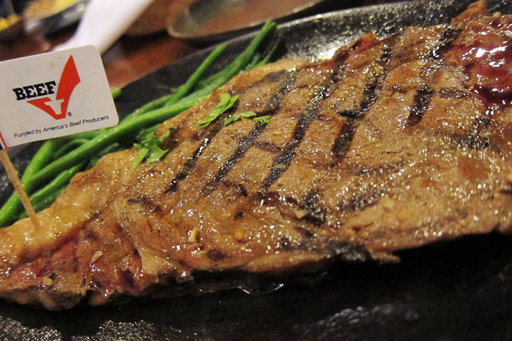

In [32]:
import random
from PIL import Image

# set seed
#random.seed(42)

# 1. get all image paths
imagePathList = list(image_path.glob("*/*/*.jpg"))

# 2. pick a random path 
randomPath = random.choice(imagePathList)

# 3. get the image class name
imageClass = randomPath.parent.stem

# 4. open image
img = Image.open(randomPath)

# 5. print metadata
print(f"Random image path: {randomPath}")
print(f"Image class: {imageClass}")
print(f"Image height: {img.height}")
print(f"Image width: {img.width}")
img

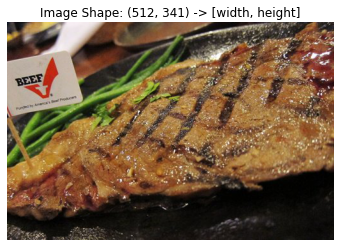

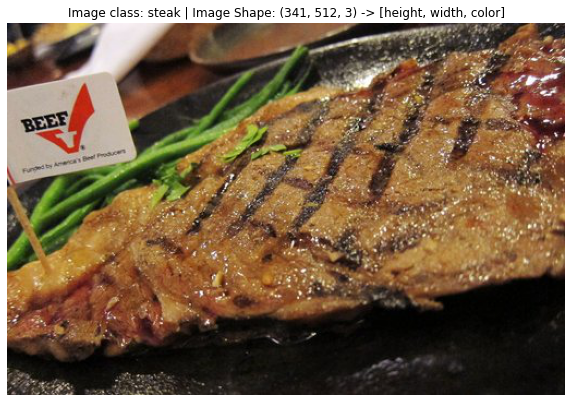

In [34]:
# visualize with matplotlib
import matplotlib.pyplot as plt
import numpy as np

plt.imshow(img);
plt.title(f"Image Shape: {img.size} -> [width, height]")
plt.axis(False);

# also turn image into an array
imgAsArray = np.asarray(img)
plt.figure(figsize=(10,7))
plt.imshow(imgAsArray);
plt.title(f"Image class: {imageClass} | Image Shape: {imgAsArray.shape} -> [height, width, color]");
plt.axis(False);

## 3. Transforming Data (into tensors format)

1. Turn target data into tensors (in this case, numerical representation of images) 
2. Turn it into a `torch.utils.data.Dataset` 
3. Turn Dataset into `torch.utils.data.DataLoader` - batched, iterable version of dataset


In [35]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

### 3.1 Transforming data with `torchvision.transforms`

In [38]:
# write a transform for the image
dataTransform = transforms.Compose([
    # resize our images to 64,64 
    transforms.Resize(size=(64,64)),
    # flip the images randomly on the horizontal 
    transforms.RandomHorizontalFlip(p=0.5),
    # turn image into torch tensor
    transforms.ToTensor() # from PIL Image of HWC -> CHW 
])

In [40]:
dataTransform(img).shape

torch.Size([3, 64, 64])

Text(0.5, 1.0, 'Visualizing Transformed image')

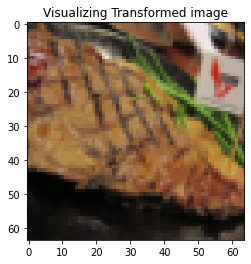

In [42]:
# Visualizing the data again
transformNumpy = dataTransform(img).numpy()

# switch axis 
transformNumpy = np.moveaxis(transformNumpy, 0, -1)

plt.imshow(transformNumpy);
plt.title(f"Visualizing Transformed image")

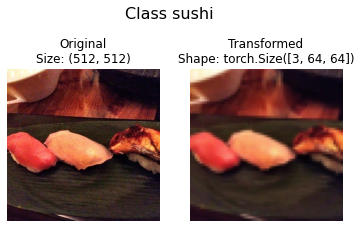

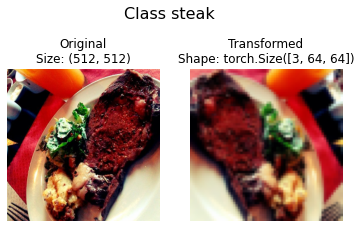

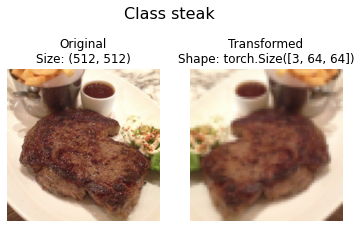

In [49]:
# Creating a function to visualize for us
def plotTransformedImage(imagePaths: list,
                         transform,
                         n=3,
                         seed=None):
  """
  Selects random images from a path of iamges and loads/transforms
  them, then plots the original vs the transformed image versions.
  """

  if seed:
    random.seed(seed)
  
  randomImagePaths = random.sample(imagePaths, k=n)

  for imagePath in randomImagePaths:
    with Image.open(imagePath) as f:
      fig, ax = plt.subplots(nrows=1, ncols=2)

      # plot original
      ax[0].imshow(f)
      ax[0].set_title(f"Original\nSize: {f.size}")
      ax[0].axis(False)

      # plot transformed
      transformedImage = transform(f)
      ax[1].imshow(transformedImage.permute(1,2,0)) # changing shape from CHW -> HWC
      ax[1].set_title(f"Transformed\nShape: {transformedImage.shape}")
      ax[1].axis(False)

      fig.suptitle(f"Class {imagePath.parent.stem}", fontsize=16)

plotTransformedImage(imagePaths=imagePathList,
                     transform=dataTransform, 
                     n=3,
                     seed=None)


## 4. Option 1: Loading image data using `ImageFolder`

We can load image classification data using  `torchvision.datasets.ImageFolder`

In [59]:
# use ImageFolder class to create dataset(s)
from torchvision import datasets

trainData = datasets.ImageFolder(root=trainDir,
                                 transform=dataTransform, # transform for the data
                                 target_transform=None) # transform for target

testData = datasets.ImageFolder(root=testDir,
                                transform=dataTransform,
                                target_transform=None)

In [63]:
# Get class names as a list
classNames = trainData.classes

# get class names as a dictionary
classDict = trainData.class_to_idx

In [65]:
# check lengths of our datasets
len(trainData), len(testData)

(225, 75)

In [69]:
# Index on the trainData dataset to get a single image and label
image, label = trainData[0]

print(f"Image tensor:\n {image}")
print(f"Image shape: {image.shape}")
print(f"Image datatype: {image.dtype}")
print(f"Label tensor:\n {label}")
print(f"Label datatype: {type(label)}")

Image tensor:
 tensor([[[0.1176, 0.1216, 0.1255,  ..., 0.0980, 0.1020, 0.1137],
         [0.1294, 0.1294, 0.1294,  ..., 0.0980, 0.0980, 0.1059],
         [0.1333, 0.1333, 0.1333,  ..., 0.0941, 0.0980, 0.1020],
         ...,
         [0.1686, 0.1647, 0.1686,  ..., 0.1255, 0.1098, 0.1098],
         [0.1686, 0.1647, 0.1686,  ..., 0.1098, 0.0941, 0.0863],
         [0.1647, 0.1647, 0.1686,  ..., 0.0980, 0.0863, 0.0863]],

        [[0.0588, 0.0588, 0.0588,  ..., 0.0745, 0.0706, 0.0745],
         [0.0627, 0.0627, 0.0627,  ..., 0.0745, 0.0706, 0.0706],
         [0.0706, 0.0706, 0.0706,  ..., 0.0745, 0.0745, 0.0706],
         ...,
         [0.2392, 0.2392, 0.2510,  ..., 0.1373, 0.1333, 0.1255],
         [0.2314, 0.2392, 0.2510,  ..., 0.1255, 0.1176, 0.1098],
         [0.2275, 0.2353, 0.2431,  ..., 0.1137, 0.1059, 0.1020]],

        [[0.0196, 0.0196, 0.0196,  ..., 0.0902, 0.0902, 0.0941],
         [0.0196, 0.0157, 0.0196,  ..., 0.0902, 0.0863, 0.0902],
         [0.0196, 0.0157, 0.0157,  ..., 0.0

Original Shape: torch.Size([3, 64, 64]) -> [color, height, width]
Permuted Shape: torch.Size([64, 64, 3]) -> [height, width, color]


Text(0.5, 1.0, 'pizza')

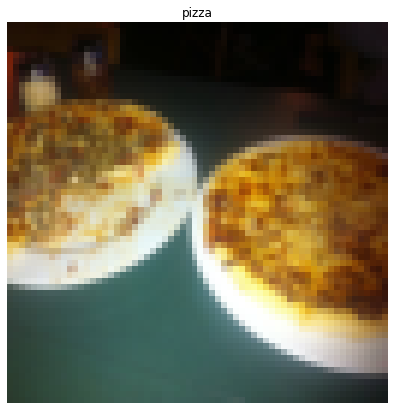

In [72]:
# Rearrange the order dimensions
imagePermute = image.permute(1, 2, 0)

# print out shape change
print(f"Original Shape: {image.shape} -> [color, height, width]")
print(f"Permuted Shape: {imagePermute.shape} -> [height, width, color]")

plt.figure(figsize=(10,7))
plt.imshow(imagePermute);
plt.axis(False);
plt.title(classNames[label])

### 4.1 Turn datasets into `DataLoader`s 

A `DataLoader` is going to make our data iterables and can customise `batch_size`

In [73]:
# Create a train DataLoader
from torch.utils.data import DataLoader

batchSize = 5

trainDataLoader = DataLoader(trainData, 
                             batch_size=batchSize,
                             shuffle=True)

testDataLoader = DataLoader(testData,
                            batch_size=batchSize,
                            shuffle=False)

NVIDIA-SMI has failed because it couldn't communicate with the NVIDIA driver. Make sure that the latest NVIDIA driver is installed and running.

